# **Doc2Vec**
This notebook is an extension to the Word2Vec model, that can be used for Documents.

In [2]:
import string
import os
import urllib.request
import io
import tarfile
import collections
import numpy as np
import requests
import gzip
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import pickle
import string
from nltk.corpus import stopwords
from tensorflow.python.framework import ops

In [3]:
ops.reset_default_graph()

data_folder_name = 'data'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

sess = tf.Session()

batch_size = 500
vocabulary_size = 7500
generations = 100000
model_learning_rate = 0.001

embedding_size = 200  # Word embedding size
doc_embedding_size = 100  # Document embedding size
concatenated_size = embedding_size + doc_embedding_size

num_sampled = int(batch_size / 2)  # Number of negative examples to sample.
window_size = 3  # How many words to consider to the left.

# Add checkpoints to training
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

# Declare stop words
# stops = stopwords.words('english')
stops = []
# valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']
valid_words = ['however', 'states', 'two', 'he', 'other', 'between','they','would','has','time','use','d','a','of','there','used']

In [4]:
def load_movie_data(file_name):
    save_folder_name = file_name
    pos_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.neg')

    if not os.path.exists(os.path.join(save_folder_name,'rt-polaritydata')):
        movie_data_url = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'

        req = requests.get(movie_data_url,stream=True)
        with open(file_name+'/temp_movie_review_temp.tar.gz', 'wb') as f:
            for chunk in req.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    f.flush()
        
        tar = tarfile.open(file_name+'/temp_movie_review_temp.tar.gz', "r:gz")
        tar.extractall(path=file_name)
        tar.close()
        
    pos_data = []
    with open(pos_file, 'r', encoding='latin-1') as f:
        for line in f:
            pos_data.append(line.encode('ascii',errors='ignore').decode())
    f.close()
    pos_data = [x.rstrip() for x in pos_data]

    neg_data = []
    with open(neg_file, 'r', encoding='latin-1') as f:
        for line in f:
            neg_data.append(line.encode('ascii',errors='ignore').decode())
    f.close()
    neg_data = [x.rstrip() for x in neg_data]

    texts = pos_data + neg_data
    target = [1]*len(pos_data) + [0]*len(neg_data)
    
    return(texts, target)

texts, target = load_movie_data(data_folder_name)
print('Data Loaded!')

Data Loaded!


In [5]:
def normalize_text(texts, stops):
    texts = [x.lower() for x in texts]
    texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
    texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
    # Remove stopwords
    texts = [' '.join([word for word in x.split() if word not in (stops)]) for x in texts]
    # Trim extra whitespace
    texts = [' '.join(x.split()) for x in texts]
    return(texts)

print('Normalizing the Text Data')
print(texts[0])
texts1 = normalize_text(texts, stops)
print(texts[0])

Normalizing the Text Data
the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .


In [6]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return tokenize_text(text)

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return ' '.join(tokens)


texts = [cleanText(x) for x in texts1]
print('\n',texts[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

 the rock is destined to be the st centurys new conan and that hes going to make splash even greater than arnold schwarzenegger jeanclaud van damme or steven segal


In [7]:
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > window_size]
texts = [x for x in texts if len(x.split()) > window_size]
assert (len(target) == len(texts))

In [8]:
def build_dictionary(sentences, vocabulary_size):
    # Turn sentences into lists of words
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    
    # Initialize list of [word, word_count] for each word
    count = []
    # Add N most frequent words
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    
    word_dict = {}
    for word, word_count in count:
        word_dict[word] = len(word_dict)
    
    return(word_dict)

def text_to_numbers(sentences, word_dict):
    data = []
    for sentence in sentences:
        sentence_data = []
        for word in sentence.split():
            if word in word_dict:
                word_ix = word_dict[word]
            else:
                word_ix = 0
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return (data)

print('Creating Dictionary')
word_dictionary = build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_to_numbers(texts, word_dictionary)

valid_examples = [word_dictionary[x] for x in valid_words if x in word_dictionary]

Creating Dictionary


In [9]:
print('Creating Model')
# Define Embeddings
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                              stddev=1.0 / np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

Creating Model


In [10]:
with tf.Session() as ses:
  print(embeddings)
  print(doc_embeddings)
  print(nce_weights)
  print(nce_biases)

<tf.Variable 'Variable:0' shape=(7500, 200) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(10395, 100) dtype=float32_ref>
<tf.Variable 'Variable_2:0' shape=(7500, 300) dtype=float32_ref>
<tf.Variable 'Variable_3:0' shape=(7500,) dtype=float32_ref>


In [11]:
x_inputs = tf.placeholder(tf.int32, shape=[None, window_size + 1])  # plus 1 for doc index
y_target = tf.placeholder(tf.int32, shape=[None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

doc_indices = tf.slice(x_inputs, [0, window_size], [batch_size, 1])
doc_embed = tf.nn.embedding_lookup(doc_embeddings, doc_indices)
squeezed = tf.squeeze(doc_embed)
final_embed = tf.concat([embed, squeezed],axis = 1)

with tf.Session() as ses:
  print(x_inputs)
  print(y_target)
  print(valid_dataset)
  print(embed)
  print(doc_indices)
  print(doc_embed)
  print(squeezed)
  print(final_embed)

Tensor("Placeholder:0", shape=(?, 4), dtype=int32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=int32)
Tensor("Const:0", shape=(14,), dtype=int32)
Tensor("add_2:0", shape=(500, 200), dtype=float32)
Tensor("Slice:0", shape=(500, 1), dtype=int32)
Tensor("embedding_lookup_3/Identity:0", shape=(500, 1, 100), dtype=float32)
Tensor("Squeeze:0", shape=(500, 100), dtype=float32)
Tensor("concat:0", shape=(500, 300), dtype=float32)


In [12]:
loss = tf.reduce_mean(tf.nn.nce_loss(weights = nce_weights, biases = nce_biases, inputs=final_embed, labels=y_target,
                                     num_sampled = num_sampled, num_classes = vocabulary_size))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optimizer.minimize(loss)

# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

saver = tf.train.Saver({"embeddings": embeddings, "doc_embeddings": doc_embeddings})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
def generate_batch_data(sentences, batch_size, window_size, method='skip_gram'):
    batch_data = []
    label_data = []

    while len(batch_data) < batch_size:
        rand_sentence_ix = int(np.random.choice(len(sentences), size=1))
        rand_sentence = sentences[rand_sentence_ix]
        # Generate consecutive windows to look 
        window_sequences = [rand_sentence[max((ix-window_size),0):(ix+window_size+1)] for ix, x in enumerate(rand_sentence)]
        label_indices = [ix if ix<window_size else window_size for ix,x in enumerate(window_sequences)]
        
        if method=='skip_gram':
            batch_and_labels = [(x[y], x[:y] + x[(y+1):]) for x,y in zip(window_sequences, label_indices)]
            tuple_data = [(x, y_) for x,y in batch_and_labels for y_ in y]
            batch, labels = [list(x) for x in zip(*tuple_data)]
        elif method=='cbow':
            batch_and_labels = [(x[:y] + x[(y+1):], x[y]) for x,y in zip(window_sequences, label_indices)]
            batch_and_labels = [(x,y) for x,y in batch_and_labels if len(x)==2*window_size]
            batch, labels = [list(x) for x in zip(*batch_and_labels)]
        elif method=='doc2vec':
            # For doc2vec we keep LHS window only to predict target word
            batch_and_labels = [(rand_sentence[i:i+window_size], rand_sentence[i+window_size]) for i in range(0, len(rand_sentence)-window_size)]
            batch, labels = [list(x) for x in zip(*batch_and_labels)]
            # Add document index to batch
            batch = [x + [rand_sentence_ix] for x in batch]
        else:
            raise ValueError('Method {} not implemented yet.'.format(method))
            
        batch_data.extend(batch[:batch_size])
        label_data.extend(labels[:batch_size])
    
    batch_data = batch_data[:batch_size]
    label_data = label_data[:batch_size]
    
    batch_data = np.array(batch_data)
    label_data = np.transpose(np.array([label_data]))
    
    return (batch_data, label_data)


In [14]:
# Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

# Run the skip gram model.
print('Starting Training')
loss_vec = []
loss_x_vec = []

for i in range(generations):
    batch_inputs, batch_labels = generate_batch_data(text_data, batch_size,
                                                                  window_size, method='doc2vec')
    feed_dict = {x_inputs: batch_inputs, y_target: batch_labels}

    # Running the train step
    sess.run(train_step, feed_dict=feed_dict)

    if (i + 1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i + 1)
        print('Loss at step {} : {}'.format(i + 1, loss_val))

    # Validation: Print top 5 related words to the validation words
    if (i + 1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_examples)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5  # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k + 1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},'.format(log_str, close_word)
            print(log_str)

    if (i + 1) % save_embeddings_every == 0:
        with open(os.path.join(data_folder_name, 'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)

        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(), data_folder_name, 'doc2vec_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training
Loss at step 100 : 659.357177734375
Loss at step 200 : 629.561767578125
Loss at step 300 : 560.5028686523438
Loss at step 400 : 557.2928466796875
Loss at step 500 : 546.6844482421875
Loss at step 600 : 515.5759887695312
Loss at step 700 : 536.0426025390625
Loss at step 800 : 509.8237609863281
Loss at step 900 : 475.0494384765625
Loss at step 1000 : 490.1079406738281
Loss at step 1100 : 472.0484924316406
Loss at step 1200 : 435.987548828125
Loss at step 1300 : 424.8429870605469
Loss at step 1400 : 469.8960876464844
Loss at step 1500 : 385.5612487792969
Loss at step 1600 : 355.343017578125
Loss at step 1700 : 344.6938781738281
Loss at step 1800 : 326.59771728515625
Loss at step 1900 : 351.0867004394531
Loss at step 2000 : 316.1169128417969
Loss at step 2100 : 320.5728759765625
Loss at step 2200 : 330.9652404785156
Loss at step 2300 : 308.0048522949219
Loss at step 2400 : 313.2032470703125
Loss at step 2500 : 286.45367431640625
Loss at step 2600 : 278.8516540527344
Loss 

In [15]:
max_words = 20
logistic_batch_size = 500

# Split dataset into train and test sets
train_indices = np.sort(np.random.choice(len(target), round(0.8 * len(target)), replace=False))
test_indices = np.sort(np.array(list(set(range(len(target))) - set(train_indices))))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# Convert texts to numeric lists
text_data_train = np.array(text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_to_numbers(texts_test, word_dictionary))

# Crop movie reviews to specific length
text_data_train = np.array([x[0:max_words] for x in [y + [0] * max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y + [0] * max_words for y in text_data_test]])

log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words + 1])  # plus 1 for doc index
log_y_target = tf.placeholder(tf.int32, shape=[None, 1])


log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])

log_doc_indices = tf.slice(log_x_inputs, [0, max_words], [logistic_batch_size, 1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings, log_doc_indices)

log_final_embed = tf.concat([log_embed, tf.squeeze(log_doc_embed)], axis=1)

# Create X & y variables for logistic regression
X = tf.Variable(tf.random_normal(shape=[concatenated_size, 1]))
y = tf.Variable(tf.random_normal(shape=[1, 1]))

model_output = tf.add(tf.matmul(log_final_embed, X), y)

logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=model_output, logits=tf.cast(log_y_target, tf.float32)))

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[X, y])

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

# Start Logistic Regression
print('Training Logistic Doc2Vec Model:')
epochs = 10000

train_loss = []
test_loss = []
train_acc = []
test_acc = []
x_data = []

for i in range(epochs):
    rand_index = np.random.choice(text_data_train.shape[0], size=logistic_batch_size)
    rand_x = text_data_train[rand_index]
    
    rand_x_doc_indices = train_indices[rand_index]
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_indices])))
    rand_y = np.transpose([target_train[rand_index]])

    feed_dict = {log_x_inputs: rand_x, log_y_target: rand_y}
    sess.run(logistic_train_step, feed_dict=feed_dict)

    # Record loss and accuracy every 100 generations
    if (i + 1) % 100 == 0:
        rand_index_test = np.random.choice(text_data_test.shape[0], size=logistic_batch_size)
        rand_x_test = text_data_test[rand_index_test]
        rand_x_doc_indices_test = test_indices[rand_index_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_indices_test])))
        rand_y_test = np.transpose([target_test[rand_index_test]])

        test_feed_dict = {log_x_inputs: rand_x_test, log_y_target: rand_y_test}

        x_data.append(i + 1)

        train_loss_temp = sess.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)

        test_loss_temp = sess.run(logistic_loss, feed_dict=test_feed_dict)
        test_loss.append(test_loss_temp)

        train_acc_temp = sess.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)

        test_acc_temp = sess.run(accuracy, feed_dict=test_feed_dict)
        test_acc.append(test_acc_temp)

    if (i + 1) % 500 == 0:
        acc_and_loss = [i + 1, train_loss_temp, train_acc_temp, test_loss_temp, test_acc_temp]
        acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        print('Epoch {}: train_loss: {:.2f}, train_acc: {:.2f}, test_loss: {:.2f}, test_acc: {:.2f}'.format(*acc_and_loss))

print('\n\nTraining finished!')

Training Logistic Doc2Vec Model:
Epoch 500: train_loss: -3318.17, train_acc: 0.48, test_loss: -3419.33, test_acc: 0.49
Epoch 1000: train_loss: -7442.11, train_acc: 0.51, test_loss: -7202.22, test_acc: 0.51
Epoch 1500: train_loss: -10027.74, train_acc: 0.51, test_loss: -10975.00, test_acc: 0.52
Epoch 2000: train_loss: -12803.68, train_acc: 0.48, test_loss: -15021.68, test_acc: 0.51
Epoch 2500: train_loss: -17039.67, train_acc: 0.47, test_loss: -15828.83, test_acc: 0.47
Epoch 3000: train_loss: -20502.33, train_acc: 0.48, test_loss: -22651.11, test_acc: 0.54
Epoch 3500: train_loss: -23490.00, train_acc: 0.50, test_loss: -23989.71, test_acc: 0.48
Epoch 4000: train_loss: -28984.86, train_acc: 0.51, test_loss: -26074.31, test_acc: 0.49
Epoch 4500: train_loss: -33344.06, train_acc: 0.53, test_loss: -30816.22, test_acc: 0.52
Epoch 5000: train_loss: -35329.38, train_acc: 0.49, test_loss: -32066.51, test_acc: 0.45
Epoch 5500: train_loss: -39122.69, train_acc: 0.50, test_loss: -33531.59, test_acc

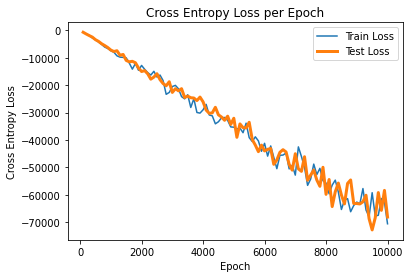

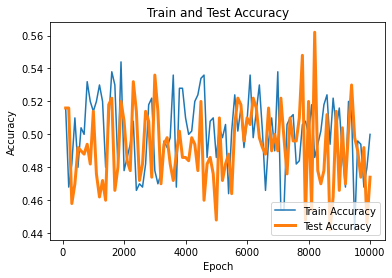

In [16]:
# Plot loss over time
plt.plot(x_data, train_loss, label='Train Loss')
plt.plot(x_data, test_loss, label='Test Loss', linewidth=3)
plt.title('Cross Entropy Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(x_data, train_acc, label='Train Accuracy')
plt.plot(x_data, test_acc, label='Test Accuracy', linewidth=3)
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()